In [1]:
import pandas as pd
from rdkit import Chem, rdBase

from rgroupinterm.rgroup_highlighting import plot_highlighted, fix_Hs
from rgroupinterm.rgroupenumeration import EnumRGroups

rdBase.DisableLog('rdApp.*')

In [2]:
smiles = [
    '[NH3+]C[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(F)(F)F)ccc1N[C@H]2c1ccccc1',
    'C[NH+](C)CCS(=O)(=O)NC[C@H]1CC[C@@H]2[C@H](O1)c1cc(Cl)cc(F)c1N[C@H]2c1ccccc1'
]

In [3]:
generator = EnumRGroups()

mols = [Chem.MolFromSmiles(x) for x in smiles]
df_interm, core = generator.generate_intermediates(mols)
intermediates = df_interm['Intermediate'].tolist()
print(len(intermediates))

6


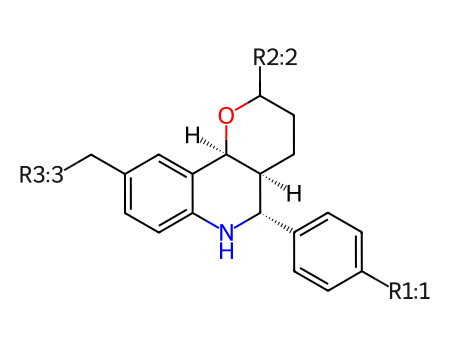

In [4]:
core

In [5]:
image = plot_highlighted(mols[0], mols[1], intermediates, core)

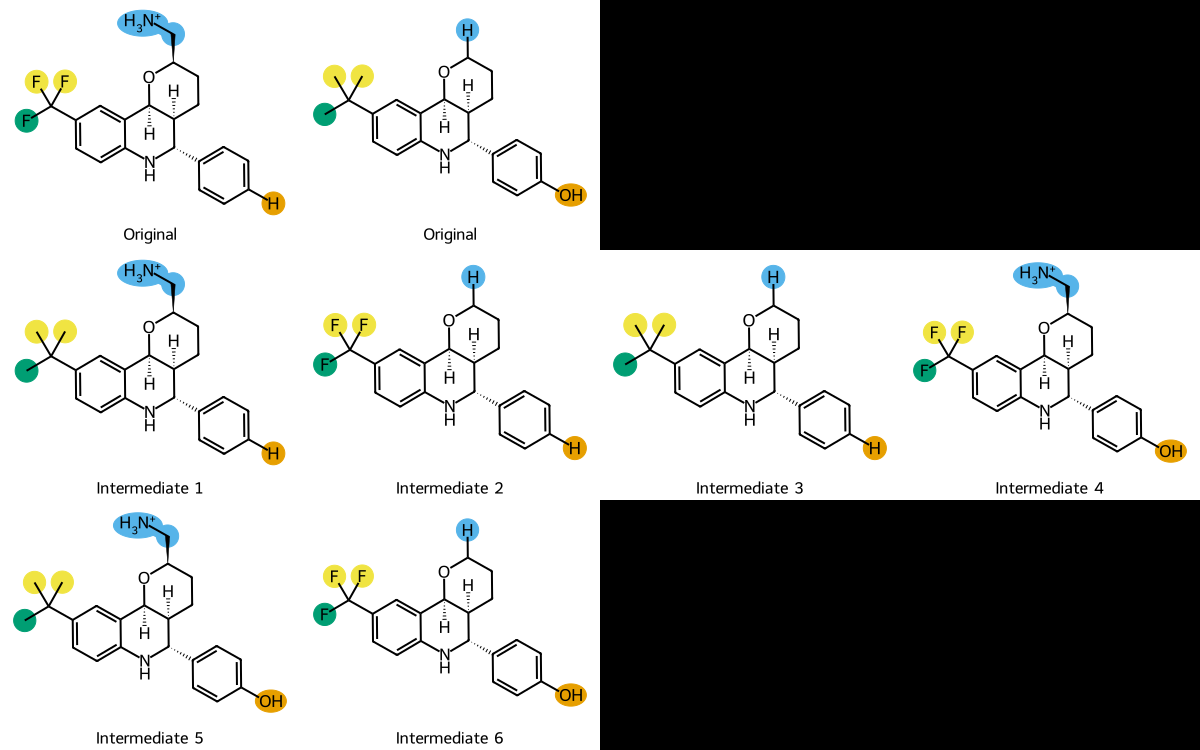

In [6]:
image